<a href="https://colab.research.google.com/github/learner0408/GANs/blob/Projects/Generating_MNIST_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import glob #Used for getting paths that match a specific pattern
import imageio #To input/output image
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import layers
import time

from IPython import display

## Loading and Preparing Data

In [3]:
#Loading MNIST Data
(train_images,train_labels),(_,_) = tf.keras.datasets.mnist.load_data() 

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
print(train_images[:5,:])
print(train_labels[:5,])

print(f"Number of Training Images:{len(train_images)}")

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[5 0 4 1 9]
Number of Training Images:60000


In [5]:
# Reshaping and Normalizing training data
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images-127.5)/127.5

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Creating Model for Generator and Discriminator

In [8]:
def create_generator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape((7,7,256)))
  assert model.output_shape==(None,7,7,256)

  model.add(tf.keras.layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias = False))
  assert model.output_shape == (None,7,7,128)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias = False))
  assert model.output_shape == (None,14,14,64)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias = False, activation='tanh'))
  assert model.output_shape == (None,28,28,1)

  return model

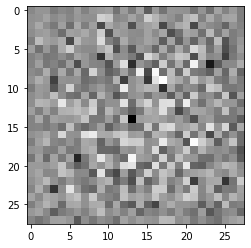

In [9]:
from tensorflow.python import training
generator = create_generator()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [10]:
def create_discriminator():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(64, (5,5), strides=(2,2),padding='same',input_shape=[28,28,1]))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Conv2D(128, (5,5), strides=(2,2),padding='same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))

  return model

In [11]:
discriminator = create_discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00192537]], shape=(1, 1), dtype=float32)


Positive output value represent real image and negative value represent fake image

## Loss and Optimizers

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss

In [13]:
def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss+fake_loss
  return total_loss

### Generator Loss

In [14]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Saving Checkpoint

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

## Creating Training Loop

In [17]:
EPOCHS = 50
noise_dim = 100
number_of_examples_to_generate = 16

seed = tf.random.normal([number_of_examples_to_generate,noise_dim])

In [18]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images)
    fake_output = discriminator(generated_images)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)
  
  gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


Generate and Save images

In [19]:
def generate_and_save_images(model,epoch,test_input):
  predictions = model(test_input,training=False)

  plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5 + 127.5, cmap='gray')
    plt.axis('off')
  

  plt.savefig(f"image_at_epoch_{epoch}.png")
  plt.show()


In [20]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch+1,seed)

    if (epoch+1)%15==0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    
    print(f"Time for epoch {epoch} is {time.time()-start} sec")
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)



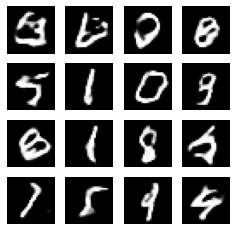

In [21]:
train(train_dataset,EPOCHS)

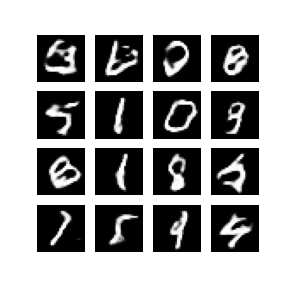

In [23]:
import PIL
def display_image(epoch):
  return PIL.Image.open(f"image_at_epoch_{epoch}.png")

display_image(EPOCHS)

In [24]:
GIF_NAME = "MNIST_GAN.gif"
def create_gif(name):
  with imageio.get_writer(name,mode='I') as writer:
    filenames = glob.glob("image*.png")
    filenames = sorted(filenames)
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

create_gif(GIF_NAME)
  

In [28]:
pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ygvmxk7p
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ygvmxk7p
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184222 sha256=bb18e92e7fca2209e8c6c7eb9ed155380e178cd77bea82e85358766fd7ba44e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-zk2e8oo6/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs



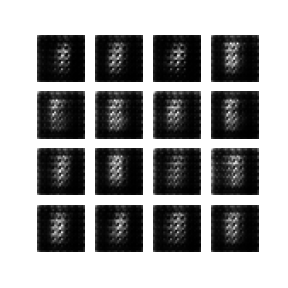

In [29]:
import tensorflow_docs.vis.embed as embed
mnist = embed.embed_file(GIF_NAME)
